ابتدا اعطای دسترسی به درایو، فراخوانی کتابخانه‌های مورد نیاز و تعریف متغیرهای سراسری مورد استفاده

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install timm
import numpy as np
import pandas as pd
import copy
import sys, os
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import densenet201
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
jupi_stdout = sys.stdout
dir = '/content/drive/MyDrive/NN_HW5/'

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.9 MB/s eta 0:00:00


<div dir='rtl'>
  خواندن دیتاست CIFAR10 در دسته‌های Train و Validation، اعمال پیش‌پردازش‌ها و تعریف دیتالودرها برای دو دسته Train و Validation
</div>

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias= None),  #interpolation=Image.BILINEAR
    transforms.RandomHorizontalFlip(),
    #transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768)), #CIFAR10 mean and std for train set
])
                              
train_dataset = CIFAR10(root= dir + '/cifar10', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root= dir + '/cifar10', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:05<00:00, 28857063.47it/s]


Extracting /content/drive/MyDrive/NN_HW5//cifar10/cifar-10-python.tar.gz to /content/drive/MyDrive/NN_HW5//cifar10
Files already downloaded and verified


تعریف کلاس مدل برای سوال و همچنین تعریف یک کلاس جهت محاسبه دقت (جزئیات مربوطه در گزارش آمدند).

In [2]:
def accuracy(target, predict):  
  if len(predict) != len(target):
    raise Exception("prediction set and target set are not at the sane length.")        
  return len([1 for i in np.array(predict) == target if i])/len(target)

class custom_model(nn.Module):
  def __init__(self, base_model):
    super(custom_model, self).__init__()       
    self.base = base_model
    self.flatten = torch.flatten
    self.linear1 = nn.Linear(1000, 256)
    self.elu = nn.ELU()
    self.dropout = nn.Dropout(0.005)
    self.linear2 = nn.Linear(256, 10)

  def forward(self, images):
    output = self.base(images)
    output = self.elu(self.linear1(output))
    output = self.linear2(self.dropout(output))
    return output

<div dir='rtl'>
  تعریف تابعی جهت train و validation مدل و همچنین چاپ نتایج
</div>

In [ ]:
def train(model, train_loader = train_loader, val_loader = test_loader, epochs = 20,
          device = device, custom_optimizer = None, custom_loss_fn = None):  
  
  l_rate= 0.0001
  model = model.to(device)
  if custom_optimizer is None:
    optimizer = torch.optim.AdamW(model.parameters(), lr= l_rate)
  else:
    optimizer = custom_optimizer
  
  if custom_loss_fn is None:
    loss_fn = nn.CrossEntropyLoss()
  else:
    loss_fn = custom_loss_fn
    
  training_loss_history = []
  validation_loss_history = []
  training_acc_history = []
  validation_acc_history = [0]
  all_validation_targets = []
  all_validation_predicts = []

  for e in range(epochs):        
    print('epoch: ', e + 1, '/', epochs)    
    print(' train phase: ')
    model.train()
    training_loss = 0 
    targets = []   
    predicts = []
    for inputs, labels in tqdm(train_loader):
      [targets.append(i) for i in labels]
      #all_targets.extend(targets)
      inputs = inputs.to(device)
      labels = labels.to(device)            
      output = model(inputs)
      [predicts.append(i) for i in output.detach().cpu().numpy().tolist()]
      #all_predicts.extend(predicts)      
      loss = loss_fn(output, labels)
      optimizer.zero_grad()      
      loss.backward()
      optimizer.step()
      training_loss += loss.item()
    training_loss = training_loss / len(train_loader)
    training_acc_history.append(accuracy(np.argmax(predicts, 1), targets))    
    training_loss_history.append(training_loss)

    print(' validation phase: ')
    model.eval()
    validation_loss = 0
    targets = []   
    predicts = []
    with torch.no_grad():
      for inputs, labels in tqdm(val_loader):        
        [targets.append(i) for i in labels]
        all_validation_targets.extend(targets)      
        inputs = inputs.to(device)
        labels = labels.to(device)        
        output = model(inputs)####feed data to model
        [predicts.append(i) for i in output.detach().cpu().numpy().tolist()]
        all_validation_predicts.extend(predicts)
        loss = loss_fn(output, labels)
        validation_loss += loss.item()
      validation_loss /= len(val_loader)
      validation_loss_history.append(validation_loss)
      validation_acc_history.append(accuracy(np.argmax(predicts, 1), targets))
      
      if validation_acc_history[-1] <= validation_acc_history[-2]:
        if l_rate * 0.6 > 0.0000001:
          l_rate *= 0.6
        else:
          l_rate = 0.0000001
        for g in optimizer.param_groups:          
          g['lr'] = l_rate

    print("epoch: ", e+1)
    print("      training loss: {:.3f}        validation loss: {:.3f}".format(training_loss_history[-1], validation_loss_history[-1]))
    print("  training accuracy: {:.3f}    validation accuracy: {:.3f}\n\n".format(training_acc_history[-1], validation_acc_history[-1]))
    #torch.save(model.state_dict(), '/content/drive/MyDrive/NN_HW5/tr_model.pth')


  result = {
    'targets': all_validation_targets,
    'predicts': all_validation_predicts, 
    'training_loss': training_loss_history,
    'validation_loss': validation_loss_history,
    'training_accuracy': training_acc_history,
    'validation_accuracy': validation_acc_history,
   }
  return result

شبکه کانولوشنی

<div dir='rtl'>
  خواندن مدل Densenet201 و بررسی لایه‌های آن:
</div>

In [3]:
densenet = densenet201(weights = 'IMAGENET1K_V1', )
densenet

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 104MB/s] 


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

چاپ اسم هر لایه جهت تشخیص بلوک آخر مدل

In [ ]:
for name, _ in densenet.named_parameters():  
  print(name)

features.conv0.weight
features.norm0.weight
features.norm0.bias
features.denseblock1.denselayer1.norm1.weight
features.denseblock1.denselayer1.norm1.bias
features.denseblock1.denselayer1.conv1.weight
features.denseblock1.denselayer1.norm2.weight
features.denseblock1.denselayer1.norm2.bias
features.denseblock1.denselayer1.conv2.weight
features.denseblock1.denselayer2.norm1.weight
features.denseblock1.denselayer2.norm1.bias
features.denseblock1.denselayer2.conv1.weight
features.denseblock1.denselayer2.norm2.weight
features.denseblock1.denselayer2.norm2.bias
features.denseblock1.denselayer2.conv2.weight
features.denseblock1.denselayer3.norm1.weight
features.denseblock1.denselayer3.norm1.bias
features.denseblock1.denselayer3.conv1.weight
features.denseblock1.denselayer3.norm2.weight
features.denseblock1.denselayer3.norm2.bias
features.denseblock1.denselayer3.conv2.weight
features.denseblock1.denselayer4.norm1.weight
features.denseblock1.denselayer4.norm1.bias
features.denseblock1.denselaye

<div dir='rtl'>
  فریز کردن لایه‌های مدل به جز لایه‌های بلوک آخر و بعد از آن
</div>

In [ ]:
for name, param in densenet.named_parameters():
  if 'denseblock4' in name or 'features.norm5' in name or 'classifier' in name:
    param.requires_grad = True
  else:
    param.requires_grad = False  

آموزش مدل به تعداد 20 ایپاک و نمایش نتیجه‌ی هر ایپاک

In [4]:
cnn_base_model = custom_model(densenet)
cnn_base_model

custom_model(
  (base): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0

In [ ]:
cnn_base_model_result = train(cnn_base_model)

epoch:  1 / 20
 train phase: 


100%|██████████| 98/98 [05:34<00:00,  3.42s/it]


 validation phase: 


100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


epoch:  1
      training loss: 0.513        validation loss: 0.290
  training accuracy: 0.831    validation accuracy: 0.898


epoch:  2 / 20
 train phase: 


100%|██████████| 98/98 [05:28<00:00,  3.35s/it]


 validation phase: 


100%|██████████| 20/20 [00:51<00:00,  2.60s/it]


epoch:  2
      training loss: 0.206        validation loss: 0.244
  training accuracy: 0.930    validation accuracy: 0.917


epoch:  3 / 20
 train phase: 


100%|██████████| 98/98 [05:27<00:00,  3.34s/it]


 validation phase: 


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


epoch:  3
      training loss: 0.122        validation loss: 0.234
  training accuracy: 0.960    validation accuracy: 0.922


epoch:  4 / 20
 train phase: 


100%|██████████| 98/98 [05:28<00:00,  3.35s/it]


 validation phase: 


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


epoch:  4
      training loss: 0.067        validation loss: 0.246
  training accuracy: 0.980    validation accuracy: 0.923


epoch:  5 / 20
 train phase: 


100%|██████████| 98/98 [05:28<00:00,  3.35s/it]


 validation phase: 


100%|██████████| 20/20 [00:53<00:00,  2.66s/it]


epoch:  5
      training loss: 0.037        validation loss: 0.246
  training accuracy: 0.990    validation accuracy: 0.925


epoch:  6 / 20
 train phase: 


100%|██████████| 98/98 [05:27<00:00,  3.34s/it]


 validation phase: 


100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


epoch:  6
      training loss: 0.020        validation loss: 0.262
  training accuracy: 0.995    validation accuracy: 0.926


epoch:  7 / 20
 train phase: 


100%|██████████| 98/98 [05:26<00:00,  3.34s/it]


 validation phase: 


100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


epoch:  7
      training loss: 0.013        validation loss: 0.271
  training accuracy: 0.997    validation accuracy: 0.929


epoch:  8 / 20
 train phase: 


100%|██████████| 98/98 [05:28<00:00,  3.35s/it]


 validation phase: 


100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


epoch:  8
      training loss: 0.009        validation loss: 0.293
  training accuracy: 0.998    validation accuracy: 0.927


epoch:  9 / 20
 train phase: 


100%|██████████| 98/98 [05:27<00:00,  3.34s/it]


 validation phase: 


100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


epoch:  9
      training loss: 0.005        validation loss: 0.308
  training accuracy: 0.999    validation accuracy: 0.928


epoch:  10 / 20
 train phase: 


100%|██████████| 98/98 [05:28<00:00,  3.35s/it]


 validation phase: 


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


epoch:  10
      training loss: 0.003        validation loss: 0.300
  training accuracy: 1.000    validation accuracy: 0.929


epoch:  11 / 20
 train phase: 


100%|██████████| 98/98 [05:27<00:00,  3.35s/it]


 validation phase: 


100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


epoch:  11
      training loss: 0.002        validation loss: 0.301
  training accuracy: 1.000    validation accuracy: 0.927


epoch:  12 / 20
 train phase: 


100%|██████████| 98/98 [05:28<00:00,  3.35s/it]


 validation phase: 


100%|██████████| 20/20 [00:53<00:00,  2.67s/it]


epoch:  12
      training loss: 0.001        validation loss: 0.308
  training accuracy: 1.000    validation accuracy: 0.927


epoch:  13 / 20
 train phase: 


100%|██████████| 98/98 [05:27<00:00,  3.35s/it]


 validation phase: 


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


epoch:  13
      training loss: 0.001        validation loss: 0.306
  training accuracy: 1.000    validation accuracy: 0.932


epoch:  14 / 20
 train phase: 


100%|██████████| 98/98 [05:28<00:00,  3.35s/it]


 validation phase: 


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


epoch:  14
      training loss: 0.001        validation loss: 0.325
  training accuracy: 1.000    validation accuracy: 0.927


epoch:  15 / 20
 train phase: 


100%|██████████| 98/98 [05:30<00:00,  3.37s/it]


 validation phase: 


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


epoch:  15
      training loss: 0.001        validation loss: 0.326
  training accuracy: 1.000    validation accuracy: 0.928


epoch:  16 / 20
 train phase: 


100%|██████████| 98/98 [05:27<00:00,  3.35s/it]


 validation phase: 


100%|██████████| 20/20 [00:52<00:00,  2.60s/it]


epoch:  16
      training loss: 0.000        validation loss: 0.306
  training accuracy: 1.000    validation accuracy: 0.930


epoch:  17 / 20
 train phase: 


100%|██████████| 98/98 [05:26<00:00,  3.33s/it]


 validation phase: 


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


epoch:  17
      training loss: 0.000        validation loss: 0.312
  training accuracy: 1.000    validation accuracy: 0.930


epoch:  18 / 20
 train phase: 


100%|██████████| 98/98 [05:28<00:00,  3.35s/it]


 validation phase: 


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


epoch:  18
      training loss: 0.000        validation loss: 0.331
  training accuracy: 1.000    validation accuracy: 0.930


epoch:  19 / 20
 train phase: 


100%|██████████| 98/98 [05:28<00:00,  3.36s/it]


 validation phase: 


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


epoch:  19
      training loss: 0.000        validation loss: 0.319
  training accuracy: 1.000    validation accuracy: 0.931


epoch:  20 / 20
 train phase: 


100%|██████████| 98/98 [05:28<00:00,  3.36s/it]


 validation phase: 


100%|██████████| 20/20 [00:52<00:00,  2.62s/it]

epoch:  20
      training loss: 0.000        validation loss: 0.332
  training accuracy: 1.000    validation accuracy: 0.929




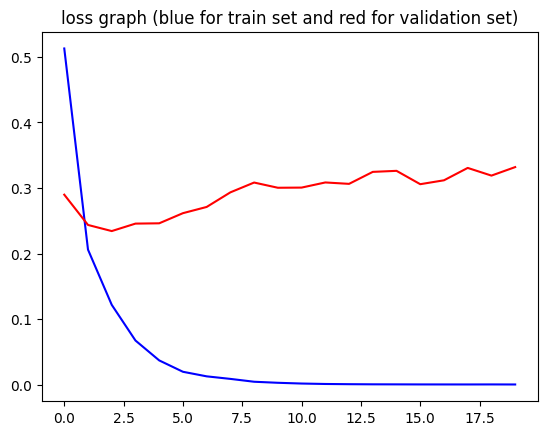

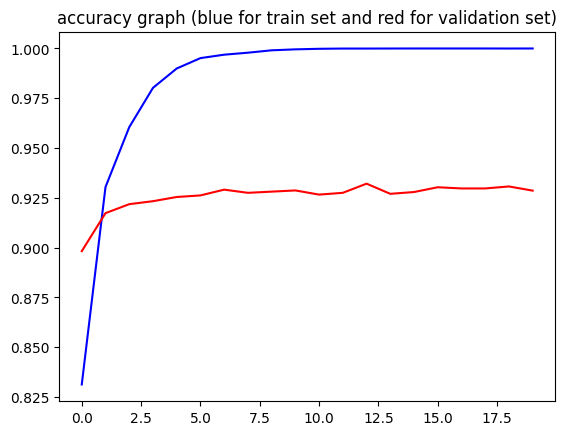

In [ ]:
di = cnn_base_model_result
#accuracy(np.argmax(di['predicts'], 1), di['targets'])
x = [i for i in range(20)]

y = di['training_loss']
y2 = di['validation_loss']
plt.title("loss graph (blue for train set and red for validation set)")
plt.plot(x, y, color ="blue")
plt.plot(x, y2, color ="red")
plt.show()

y = di['training_accuracy']
y2 = di['validation_accuracy'][1:]
plt.title("accuracy graph (blue for train set and red for validation set)")
plt.plot(x, y, color ="blue")
plt.plot(x, y2, color ="red")
plt.show()

<div dir='rtl'>
  مدل ViT (ترنسفورمری)
</div>

مراحل فوق (مدل کانوولوشنی) را عینا برای این مدل نیز تکرار میکنیم

In [5]:
cait = timm.create_model('cait_s24_224.fb_dist_in1k', pretrained=True)
cait

Cait(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): LayerScaleBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): TalkingHeadAttn(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_l): Linear(in_features=8, out_features=8, bias=True)
        (proj_w): Linear(in_features=8, out_features=8, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

In [ ]:
for name, _ in cait.named_parameters():
  print(name)

cls_token
pos_embed
patch_embed.proj.weight
patch_embed.proj.bias
blocks.0.gamma_1
blocks.0.gamma_2
blocks.0.norm1.weight
blocks.0.norm1.bias
blocks.0.attn.qkv.weight
blocks.0.attn.qkv.bias
blocks.0.attn.proj.weight
blocks.0.attn.proj.bias
blocks.0.attn.proj_l.weight
blocks.0.attn.proj_l.bias
blocks.0.attn.proj_w.weight
blocks.0.attn.proj_w.bias
blocks.0.norm2.weight
blocks.0.norm2.bias
blocks.0.mlp.fc1.weight
blocks.0.mlp.fc1.bias
blocks.0.mlp.fc2.weight
blocks.0.mlp.fc2.bias
blocks.1.gamma_1
blocks.1.gamma_2
blocks.1.norm1.weight
blocks.1.norm1.bias
blocks.1.attn.qkv.weight
blocks.1.attn.qkv.bias
blocks.1.attn.proj.weight
blocks.1.attn.proj.bias
blocks.1.attn.proj_l.weight
blocks.1.attn.proj_l.bias
blocks.1.attn.proj_w.weight
blocks.1.attn.proj_w.bias
blocks.1.norm2.weight
blocks.1.norm2.bias
blocks.1.mlp.fc1.weight
blocks.1.mlp.fc1.bias
blocks.1.mlp.fc2.weight
blocks.1.mlp.fc2.bias
blocks.2.gamma_1
blocks.2.gamma_2
blocks.2.norm1.weight
blocks.2.norm1.bias
blocks.2.attn.qkv.weight
b

In [ ]:
for name, param in cait.named_parameters():
  if '23' in name or 'blocks_token_only' in name or 'head' in name:
    param.requires_grad = True
  elif name == 'norm.bias' or name == 'norm.weight':
    param.requires_grad = True
  else:
    param.requires_grad = False


In [7]:
tr_base_model = custom_model(cait)
tr_base_model

custom_model(
  (base): Cait(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): LayerScaleBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): TalkingHeadAttn(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_l): Linear(in_features=8, out_features=8, bias=True)
          (proj_w): Linear(in_features=8, out_features=8, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
    

In [ ]:
tr_base_model_result = train(tr_base_model)

epoch:  1 / 20
 train phase: 


100%|██████████| 98/98 [08:56<00:00,  5.48s/it]


 validation phase: 


100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


epoch:  1
      training loss: 0.298        validation loss: 0.118
  training accuracy: 0.921    validation accuracy: 0.959


epoch:  2 / 20
 train phase: 


100%|██████████| 98/98 [09:04<00:00,  5.56s/it]


 validation phase: 


100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


epoch:  2
      training loss: 0.086        validation loss: 0.103
  training accuracy: 0.971    validation accuracy: 0.965


epoch:  3 / 20
 train phase: 


100%|██████████| 98/98 [09:03<00:00,  5.55s/it]


 validation phase: 


100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


epoch:  3
      training loss: 0.051        validation loss: 0.108
  training accuracy: 0.984    validation accuracy: 0.963


epoch:  4 / 20
 train phase: 


100%|██████████| 98/98 [09:04<00:00,  5.56s/it]


 validation phase: 


100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


epoch:  4
      training loss: 0.025        validation loss: 0.107
  training accuracy: 0.994    validation accuracy: 0.970


epoch:  5 / 20
 train phase: 


100%|██████████| 98/98 [09:04<00:00,  5.56s/it]


 validation phase: 


100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


epoch:  5
      training loss: 0.013        validation loss: 0.117
  training accuracy: 0.997    validation accuracy: 0.966


epoch:  6 / 20
 train phase: 


100%|██████████| 98/98 [09:06<00:00,  5.58s/it]


 validation phase: 


100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


epoch:  6
      training loss: 0.007        validation loss: 0.124
  training accuracy: 0.999    validation accuracy: 0.967


epoch:  7 / 20
 train phase: 


100%|██████████| 98/98 [09:05<00:00,  5.57s/it]


 validation phase: 


100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


epoch:  7
      training loss: 0.004        validation loss: 0.129
  training accuracy: 0.999    validation accuracy: 0.968


epoch:  8 / 20
 train phase: 


100%|██████████| 98/98 [09:04<00:00,  5.55s/it]


 validation phase: 


100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


epoch:  8
      training loss: 0.003        validation loss: 0.134
  training accuracy: 1.000    validation accuracy: 0.969


epoch:  9 / 20
 train phase: 


100%|██████████| 98/98 [09:04<00:00,  5.56s/it]


 validation phase: 


100%|██████████| 20/20 [01:40<00:00,  5.04s/it]


epoch:  9
      training loss: 0.002        validation loss: 0.137
  training accuracy: 1.000    validation accuracy: 0.969


epoch:  10 / 20
 train phase: 


100%|██████████| 98/98 [09:05<00:00,  5.56s/it]


 validation phase: 


100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


epoch:  10
      training loss: 0.001        validation loss: 0.140
  training accuracy: 1.000    validation accuracy: 0.969


epoch:  11 / 20
 train phase: 


100%|██████████| 98/98 [09:05<00:00,  5.56s/it]


 validation phase: 


100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


epoch:  11
      training loss: 0.001        validation loss: 0.146
  training accuracy: 1.000    validation accuracy: 0.968


epoch:  12 / 20
 train phase: 


100%|██████████| 98/98 [09:05<00:00,  5.57s/it]


 validation phase: 


100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


epoch:  12
      training loss: 0.001        validation loss: 0.142
  training accuracy: 1.000    validation accuracy: 0.968


epoch:  13 / 20
 train phase: 


100%|██████████| 98/98 [09:03<00:00,  5.55s/it]


 validation phase: 


100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


epoch:  13
      training loss: 0.001        validation loss: 0.148
  training accuracy: 1.000    validation accuracy: 0.968


epoch:  14 / 20
 train phase: 


100%|██████████| 98/98 [09:04<00:00,  5.55s/it]


 validation phase: 


100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


epoch:  14
      training loss: 0.001        validation loss: 0.148
  training accuracy: 1.000    validation accuracy: 0.968


epoch:  15 / 20
 train phase: 


100%|██████████| 98/98 [09:03<00:00,  5.55s/it]


 validation phase: 


100%|██████████| 20/20 [01:40<00:00,  5.04s/it]


epoch:  15
      training loss: 0.001        validation loss: 0.150
  training accuracy: 1.000    validation accuracy: 0.968


epoch:  16 / 20
 train phase: 


100%|██████████| 98/98 [09:03<00:00,  5.55s/it]


 validation phase: 


100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


epoch:  16
      training loss: 0.001        validation loss: 0.150
  training accuracy: 1.000    validation accuracy: 0.968


epoch:  17 / 20
 train phase: 


100%|██████████| 98/98 [09:05<00:00,  5.57s/it]


 validation phase: 


100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


epoch:  17
      training loss: 0.001        validation loss: 0.157
  training accuracy: 1.000    validation accuracy: 0.968


epoch:  18 / 20
 train phase: 


100%|██████████| 98/98 [09:03<00:00,  5.54s/it]


 validation phase: 


100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


epoch:  18
      training loss: 0.001        validation loss: 0.153
  training accuracy: 1.000    validation accuracy: 0.968


epoch:  19 / 20
 train phase: 


100%|██████████| 98/98 [09:04<00:00,  5.55s/it]


 validation phase: 


100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


epoch:  19
      training loss: 0.001        validation loss: 0.150
  training accuracy: 1.000    validation accuracy: 0.968


epoch:  20 / 20
 train phase: 


100%|██████████| 98/98 [09:04<00:00,  5.56s/it]


 validation phase: 


100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


epoch:  20
      training loss: 0.001        validation loss: 0.157
  training accuracy: 1.000    validation accuracy: 0.968




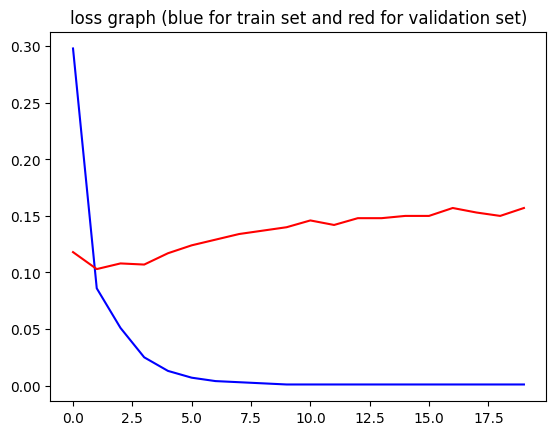

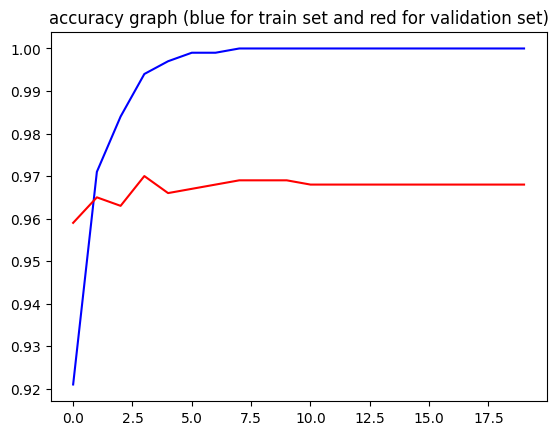

In [ ]:
di = cnn_base_model_result

x = [i for i in range(20)]

y = di['training_loss']
y2 = di['validation_loss']
plt.title("loss graph (blue for train set and red for validation set)")
plt.plot(x, y, color ="blue")
plt.plot(x, y2, color ="red")
plt.show()

y = di['training_accuracy']
y2 = di['validation_accuracy'][1:]
plt.title("accuracy graph (blue for train set and red for validation set)")
plt.plot(x, y, color ="blue")
plt.plot(x, y2, color ="red")
plt.show()